# 1D Diagnostic Simulations

This notebook implements and runs 1 dimensional diagnostic simulations to validate our theoretical analysis.

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd

## Environment

The 1 dimensional environment consists of 10 states numbered from 1 to 10, with 10 being the terminal state. The action space consists of going left, staying in the current state and going right. We let ```delta``` refer to the noise in the environment, which is a hyperparameter. More formally, for any time step $t'$, if an agent takes action $a_{t'}$ from $s_{t'}$, they will reach some state $g_{t'}$ with probability $1- \delta$ i.e $P(S_{t'} = g_{t'}|s_{t'-1}, a_{t'-1}) = 1 - \delta$. We let $P(S_{t'}|s_{t'-1}, a_{t'-1}, S_{t'} \neq g_{t'})$ be an arbitrary distribution (for example, a uniform distribution) that sums to $\delta$ over $\mathcal{S}\backslash \{ g_{t'}\}$. So, in a deterministic environment with $\delta = 0$, $P(S_{t'} = g_{t'}|s_{t'-1}, a_{t'-1}) = 1$ whereas in a noisy environment (where $\delta$ is close to 1), the probability becomes infinitesimally small. 

**Goal**: reach the terminal state. 

**Instructions:**
Change the value of delta below to generate the plot for each noise level. 

### Parameters

In [3]:
# noise in environment 
delta = 0.8

# number of states
num_states = 10

# number of actions
num_actions = 3 # 1 for left, 2 for stay, 3 for right

# maximum action horizon we consider
max_horizon = 10

## Expert Policy

The expert's context length is 5 i.e their action at time $t$ is conditioned on $s_t, s_{t-1},\cdots, s_{t-5}$. The policy is to go right in every state other than state 5 where the expert will be idle unless the last five states were all state 5 i.e $s_t = s_{t-1} = \cdots = s_{t-5} = 5$. 

In [4]:
def expert_policy(s_t, s_tminus1, s_tminus2, s_tminus3, s_tminus4, s_tminus5):
    if s_t == 5:
        if s_tminus1 == 5 and s_tminus2 == 5 and s_tminus3 == 5 and s_tminus4 == 5 and s_tminus5 == 5:
            return [3] # go right
        else:
            return [2] # stay idle
    return [3] # go right

## Expert Demonstrations

Collect expert demonstrations stored as trajectories, each containing tuples of the form (state visited, action taken).

In [5]:
def collect_data(delta, num_trajectories=1000):
    trajectories = []
    for _ in range(num_trajectories):
        trajectory = []
        states = [1] * 6  # Initialize the last 6 states to the starting state
        current_state = states[-1]

        while current_state < 10:
            actions = expert_policy(states[-1], states[-2], states[-3], states[-4], states[-5], states[-6])
            for a_t in actions:
                trajectory.append((current_state, a_t))
                if a_t == 1:
                    current_state -= 1 if np.random.rand() <= (1 - delta) else current_state + 1
                elif a_t == 3:
                    current_state += 1 if np.random.rand() <= (1 - delta) else current_state
                elif a_t == 2:
                    current_state = current_state if np.random.rand() <= (1 - delta) else current_state + 1
                states.append(current_state)
        
        trajectories.append([(1, 2)]*max_horizon + trajectory + [(10, 2)]*max_horizon)
    
    return trajectories

trajectories = collect_data(delta)

## Expert's Idle Action Distribution 

Investigate the distribution of idle actions taken by the expert.

In [6]:
def increment_count(action, idle_counts, idle_count, current_state, delta):
    ''' 
    Helper function to increment the idle count at each state based on the action taken by the agent and 
    to update the current state based on the action taken by the agent and noise in the environment. 
    '''
    if action == 2:
        idle_counts[current_state - 1] += 1
        idle_count += 1
        current_state = current_state if np.random.rand() <= 1 - delta else current_state + 1
    elif action == 1:
        current_state = current_state - 1 if np.random.rand() <= 1 - delta else current_state + 1
    elif action == 3:
        current_state = current_state + 1 if np.random.rand() <= (1 - delta) else current_state
    return idle_counts, idle_count, current_state


def act_expert(delta, num_episodes=100):
    idle_counts = np.zeros(num_states)
    idle_counts_nums = []

    for _ in range(num_episodes):
        current_state = 1
        states = [1] * 6  # Initialize the last 6 states to the starting state
        idle_count = 0

        while current_state < 10:
            actions = expert_policy(states[-1], states[-2], states[-3], states[-4], states[-5], states[-6])
            for a_t in actions:
                idle_counts, idle_count, current_state = increment_count(a_t, idle_counts, idle_count, current_state, delta)
                states.append(current_state)
                if current_state >= 10 or current_state <= 0:
                    break
        
        idle_counts_nums.append(idle_count)

    return idle_counts / num_episodes, idle_counts_nums

idle_counts_expert, idle_counts_nums_expert = act_expert(delta)
print(idle_counts_expert)
print(idle_counts_nums_expert)

[0.   0.   0.   0.   1.19 0.   0.   0.   0.   0.  ]
[1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]


## Agent Policy

Define a policy with context length = 1 and action horizon = ```ah```. The policy models the joint distribution of the next ```ah``` actions conditioned on the current state observation by by simply counting from the expert demonstrations. In other words, given $s_t$, the agent's policy is a distribution calculated by the number of times each $a_t$ was taken by the expert and the normalized by the total number of times the expert visited $s_t$.  

In [7]:
def generate_policy(trajectories, s_t, ah):
    actions = []
    for trajectory in trajectories:
        for i in range(10, len(trajectory) - ah):
            if trajectory[i][0] == s_t:
                    action = []
                    for j in range(ah):
                        action.append(trajectory[i+j][1])
                    actions.append(action)

    if len(actions) == 0:
        print('Random action')
        # make a random distribution that sums to 1
        action_distribution = np.random.rand(num_actions, ah)
        action_distribution = action_distribution / np.sum(action_distribution, axis=0)
    else:
        action_distribution = np.zeros((num_actions, ah))
        for action in actions:
            for j in range(ah):
                action_distribution[action[j]-1][j] += 1
        
        action_distribution = action_distribution / np.sum(action_distribution, axis=0)
    
    return action_distribution

policy_cache = {}

def get_policy(s_t, ah, trajectories):
    if s_t not in policy_cache:
        policy_cache[s_t] = generate_policy(trajectories, s_t, ah)
    return policy_cache[s_t]


def act_agent(ah, delta, trajectories, num_episodes=100):
    idle_counts_per_state = np.zeros(num_states)
    idle_counts_nums = []

    for _ in range(num_episodes):
        current_state = 1
        states = [1] * 6  # Initialize the last 6 states to the starting state
        idle_count = 0

        while current_state < 10:
            policy = get_policy(states[-1], ah, trajectories)
            actions = [np.random.choice([1, 2, 3], p=policy[:, i]) for i in range(ah)]

            for a_t in actions:
                idle_counts_per_state, idle_count, current_state = increment_count(a_t, idle_counts_per_state, idle_count, current_state, delta)
                states.append(current_state)
                if current_state >= 10 or current_state <= 0:
                    break
        
        idle_counts_nums.append(idle_count)

    return idle_counts_per_state / num_episodes, idle_counts_nums

## Relationship between Idle Action Distribution and Action Horizon
Create multiple agents with varying action horizons and investigate the distribution of idle actions taken by each.

Noise = 0.8


Action Horizon,TVD
1,0.05
3,5.31
5,7.12
7,8.45
10,8.71


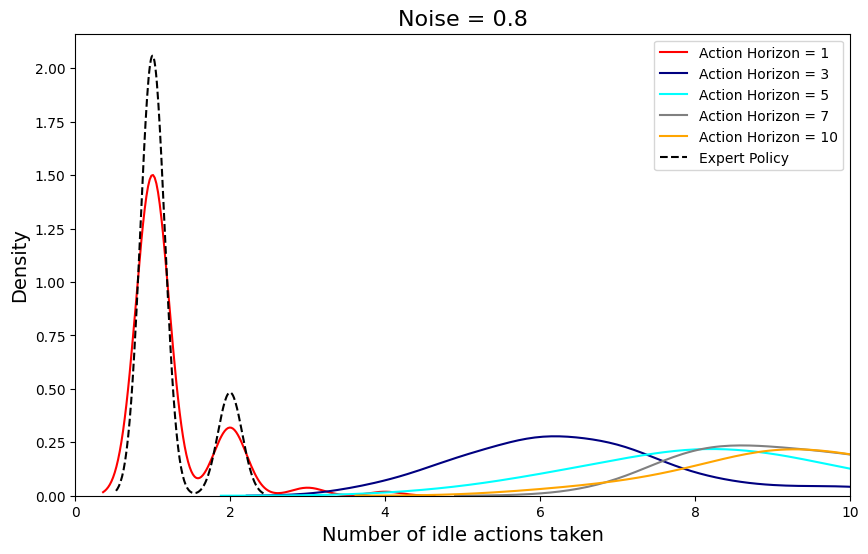

In [11]:

def run_experiments(action_horizons, delta, trajectories):
    results = {}
    for ah in action_horizons:
        policy_cache.clear()
        idle_counts, idle_counts_nums = act_agent(ah, delta, trajectories)
        results[ah] = (idle_counts, idle_counts_nums)
    return results

action_horizons = [1, 3, 5, 7, 10]
results = run_experiments(action_horizons, delta, trajectories)

# Plot the results
tvds = []

print(f'Noise = {delta}')
for ah, (idle_counts, idle_counts_nums) in results.items():
    tvds.append(stats.wasserstein_distance(idle_counts_nums, idle_counts_nums_expert))
    # print(f'Total Variation Distance between Action Horizon = {ah} and Expert Policy: {tvds[-1]}')

# pandas dataframe for the tvds
from IPython.display import display, HTML
df = pd.DataFrame({'Action Horizon': action_horizons, 'TVD': tvds})
display(HTML(df.to_html(index=False, border=1)))

# Plot KDEs
plt.figure(figsize=(10, 6))
colors = ['red', 'navy', 'cyan', 'grey', 'orange']
for i, ah in enumerate(action_horizons):
    sns.kdeplot(results[ah][1], color=colors[i], label=f'Action Horizon = {ah}', fill=False)
sns.kdeplot(idle_counts_nums_expert, label='Expert Policy', color='black', linestyle='--', fill=False)

# if tvd is 0, plot a vertical line at the mean
for i in range(len(tvds)):
    if tvds[i] == 0:
        plt.axvline(x=results[action_horizons[i]][1][0], color=colors[i], label=f'Action Horizon = {action_horizons[i]}')

# if idle_counts_nums_expert has 0 variance, plot a vertical line at the mean
if np.var(idle_counts_nums_expert) == 0:
    plt.axvline(x=idle_counts_nums_expert[0], color='black', linestyle='--', label='Expert Policy')

plt.legend(fontsize=10)
plt.xlabel('Number of idle actions taken', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim(0, 10)
plt.title(f"Noise = {delta}", fontsize=16)
plt.show()